In [1]:
#setup 
import numpy as np
import pandas as pd 
from tkinter import filedialog
import matplotlib.pyplot as plt
import os 
import glob
import csv
import itertools

In [2]:
#Dialog box 
initialdir='/home/jasonk0401/Desktop/UROP/' #assign a directory 
#filepaths= filedialog.askopenfilename(multiple=True, initialdir=initialdir,title='Select a File', filetypes=(("ASC Files",".ASC"),))
#^opens dialogbox to select multiple files that end in .ASC
#print(filepaths)

In [3]:
def list_files(filepath, filetype):
    paths=[]
    for root, dirs, files in os.walk(filepath):
        for name in files:
            if name.lower().endswith(filetype.lower()):
                paths.append(name)
    return(paths)

In [4]:
filenames= list_files(initialdir, '.asc')
print(filenames)

['INZ3UM.ASC', 'GAZ3UM.ASC', 'ALZ3UM.ASC', 'ZNO3UM3.ASC']


In [5]:
#remove .ASC from filenames for legend
#create new list
molecule_names=[] 
#for everyname in filenames split name and .asc 
#append name to new list 
for name in filenames:
    m=os.path.splitext(name)[0]
    molecule_names.append(m)
print(molecule_names)

['INZ3UM', 'GAZ3UM', 'ALZ3UM', 'ZNO3UM3']


In [6]:
#Compliling Files Into List of Lists
df=pd.DataFrame()
for element in filenames:
    df2=pd.read_csv(element, usecols=['Wavelength','Intensity'])
    df=pd.concat([df,df2], axis=1)
print(df)

     Wavelength  Intensity  Wavelength  Intensity  Wavelength  Intensity  \
0     531.77081   393210.0   531.77081   393210.0   531.77081   393210.0   
1     531.84149   393210.0   531.84149   393210.0   531.84149   393210.0   
2     531.91216   214121.0   531.91216   197919.0   531.91216   243432.0   
3     531.98284    23412.0   531.98284    22679.0   531.98284    26123.0   
4     532.05351    11086.0   532.05351    10607.0   532.05351    10128.0   
..          ...        ...         ...        ...         ...        ...   
571   571.76997     1472.0   571.76997     1052.0   571.76997     3334.0   
572   571.83939     1486.0   571.83939     1002.0   571.83939     3487.0   
573   571.90881     1524.0   571.90881     1058.0   571.90881     3442.0   
574   571.97823     1502.0   571.97823     1118.0   571.97823     3416.0   
575   572.04764     1794.0   572.04764     1317.0   572.04764     3723.0   

     Wavelength  Intensity  
0     531.77081   393210.0  
1     531.84149   393210.0  


In [7]:
#create individual names for each col
cols = []
count = 1
for column in df.columns:
    if column=='Wavelength':
        cols.append(f'Wavelength_{count}')
        count+=1
        continue
    cols.append(column)
df.columns = cols
cols = []
count = 1
for column in df.columns:
    if column=='Intensity':
        cols.append(f'Intensity_{count}')
        count+=1
        continue
    cols.append(column)
df.columns = cols
print(df)

     Wavelength_1  Intensity_1  Wavelength_2  Intensity_2  Wavelength_3  \
0       531.77081     393210.0     531.77081     393210.0     531.77081   
1       531.84149     393210.0     531.84149     393210.0     531.84149   
2       531.91216     214121.0     531.91216     197919.0     531.91216   
3       531.98284      23412.0     531.98284      22679.0     531.98284   
4       532.05351      11086.0     532.05351      10607.0     532.05351   
..            ...          ...           ...          ...           ...   
571     571.76997       1472.0     571.76997       1052.0     571.76997   
572     571.83939       1486.0     571.83939       1002.0     571.83939   
573     571.90881       1524.0     571.90881       1058.0     571.90881   
574     571.97823       1502.0     571.97823       1118.0     571.97823   
575     572.04764       1794.0     572.04764       1317.0     572.04764   

     Intensity_3  Wavelength_4  Intensity_4  
0       393210.0     531.77081     393210.0  
1      

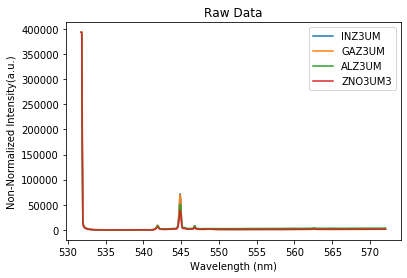

In [8]:
#Plotting Raw Data
test='Intensity'
IntCols = [idx for idx in df if idx.lower().startswith(test.lower())]
#print(IntCols)
df.plot(x='Wavelength_1', y=IntCols)
plt.title('Raw Data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Non-Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [9]:
#Skip first 300 rows to get rid of rayleigh line
df_no_rayleigh=df.drop(df.index[0:50])
#leaves rows as 250-575
#reset index becasuse it causes problems later when concating 
df_no_rayleigh.reset_index(drop=True, inplace=True)
print(df_no_rayleigh)

     Wavelength_1  Intensity_1  Wavelength_2  Intensity_2  Wavelength_3  \
0       535.30197         39.0     535.30197          0.0     535.30197   
1       535.37254         14.0     535.37254          0.0     535.37254   
2       535.44310         11.0     535.44310          3.0     535.44310   
3       535.51367          8.0     535.51367         19.0     535.51367   
4       535.58423          0.0     535.58423          0.0     535.58423   
..            ...          ...           ...          ...           ...   
521     571.76997       1472.0     571.76997       1052.0     571.76997   
522     571.83939       1486.0     571.83939       1002.0     571.83939   
523     571.90881       1524.0     571.90881       1058.0     571.90881   
524     571.97823       1502.0     571.97823       1118.0     571.97823   
525     572.04764       1794.0     572.04764       1317.0     572.04764   

     Intensity_3  Wavelength_4  Intensity_4  
0            4.0     535.30197          0.0  
1      

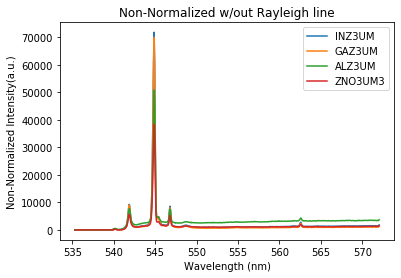

In [10]:
#Plotting Non-Normalized w/out Rayleigh line n Wavelength (nm)
test='Intensity'
IntCols = [idx for idx in df_no_rayleigh if idx.lower().startswith(test.lower())]
#print(IntCols)
df_no_rayleigh.plot(x='Wavelength_1', y=IntCols)
plt.title('Non-Normalized w/out Rayleigh line')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Non-Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [11]:
#Wavelength (nm) and Normalized Intensity 
#create list of columns that start with Intensity
test='Intensity'
test2='Wavelength'
IntCols = [idx for idx in df_no_rayleigh if idx.lower().startswith(test.lower())]
WavCols= [idx for idx in df_no_rayleigh if idx.lower().startswith(test2.lower())]
df_normalized=pd.DataFrame()
#for columns in df if they start with Intensity 
#apply calculation to columns that start with Intensity 
for col in df_no_rayleigh:
    if col.startswith(test):
        df_normalized[IntCols] = (df_no_rayleigh[IntCols].apply(lambda x: x/x.max())) #divide each number in a column by the max of that column
    if col.startswith(test2):
        df_normalized[WavCols] = df_no_rayleigh[WavCols]
print(df_normalized)

     Wavelength_1  Wavelength_2  Wavelength_3  Wavelength_4  Intensity_1  \
0       535.30197     535.30197     535.30197     535.30197     0.000543   
1       535.37254     535.37254     535.37254     535.37254     0.000195   
2       535.44310     535.44310     535.44310     535.44310     0.000153   
3       535.51367     535.51367     535.51367     535.51367     0.000111   
4       535.58423     535.58423     535.58423     535.58423     0.000000   
..            ...           ...           ...           ...          ...   
521     571.76997     571.76997     571.76997     571.76997     0.020505   
522     571.83939     571.83939     571.83939     571.83939     0.020700   
523     571.90881     571.90881     571.90881     571.90881     0.021229   
524     571.97823     571.97823     571.97823     571.97823     0.020923   
525     572.04764     572.04764     572.04764     572.04764     0.024991   

     Intensity_2  Intensity_3  Intensity_4  
0       0.000000     0.000079     0.000000

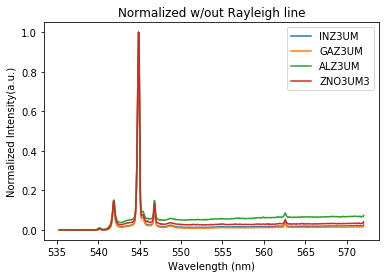

In [12]:
#Plotting Normalized w/out Rayleigh line in Wavelength (nm)
#probably dont need this everytime since IntCols is defined above
test='Intensity'
IntCols = [idx for idx in df_normalized if idx.lower().startswith(test.lower())]
#print(IntCols)
df_normalized.plot(x='Wavelength_1', y=IntCols)
plt.title('Normalized w/out Rayleigh line')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [13]:
#Raman Sh cm^-1 and Normalized Intensity 
#setup numbers for conversion 
test='Intensity'
test2='Wavelength'
IntCols = [idx for idx in df_no_rayleigh if idx.lower().startswith(test.lower())]
WavCols= [idx for idx in df_no_rayleigh if idx.lower().startswith(test2.lower())]
Excitation_Wavelength=532
a=10**7/Excitation_Wavelength
#for columns in df if they start with Intensity 
#apply calculation to columns that start with Intensity 
df_raman_shift=pd.DataFrame()
for col in df:
    if col.startswith(test):
        df_raman_shift[IntCols] = (df_normalized[IntCols])
    if col.startswith(test2):
        df_raman_shift[WavCols]= (df_normalized[WavCols].apply(lambda x:-10**7/x + a))
print(df_raman_shift)

     Wavelength_1  Wavelength_2  Wavelength_3  Wavelength_4  Intensity_1  \
0      115.947836    115.947836    115.947836    115.947836     0.000543   
1      118.410274    118.410274    118.410274    118.410274     0.000195   
2      120.871713    120.871713    120.871713    120.871713     0.000153   
3      123.332853    123.332853    123.332853    123.332853     0.000111   
4      125.792995    125.792995    125.792995    125.792995     0.000000   
..            ...           ...           ...           ...          ...   
521   1307.441570   1307.441570   1307.441570   1307.441570     0.020505   
522   1309.564761   1309.564761   1309.564761   1309.564761     0.020700   
523   1311.687438   1311.687438   1311.687438   1311.687438     0.021229   
524   1313.809599   1313.809599   1313.809599   1313.809599     0.020923   
525   1315.930939   1315.930939   1315.930939   1315.930939     0.024991   

     Intensity_2  Intensity_3  Intensity_4  
0       0.000000     0.000079     0.000000

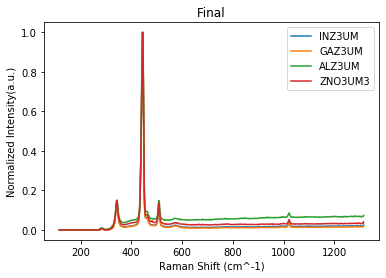

In [14]:
#Plotting Normalized w/out Rayleigh line in Wavenumber (cm^-1)
test='Intensity'
IntCols = [idx for idx in df_raman_shift if idx.lower().startswith(test.lower())]
#print(IntCols)2
df_raman_shift.plot(x='Wavelength_1', y=IntCols)
plt.title('Final')
plt.xlabel('Raman Shift (cm^-1)')
plt.ylabel('Normalized Intensity(a.u.)')
plt.legend(molecule_names)

In [15]:
IntCols1 = [idx for idx in df if idx.lower().startswith(test.lower())]
y1=IntCols1
IntCols2 = [idx for idx in df_no_rayleigh if idx.lower().startswith(test.lower())]
y2=IntCols2
IntCols3 = [idx for idx in df_normalized if idx.lower().startswith(test.lower())]
y3=IntCols3
IntCols4 = [idx for idx in df_raman_shift if idx.lower().startswith(test.lower())]
y4=IntCols4
#print

In [16]:
#figure, axes = plt.subplots(1, 4)
#df.plot(x='Wavelength_1', y=y1, ax=axes[0])
#plt.legend(molecule_names)
#df_no_rayleigh.plot(x='Wavelength_1', y=y2, ax=axes[1])
#plt.legend(molecule_names)
#df_normalized.plot(x='Wavelength_1', y=y3, ax=axes[2])
#plt.legend(molecule_names)
#df_raman_shift.plot(x='Wavelength_1', y=y4, ax=axes[3])
#plt.legend(molecule_names)
#plt.show()

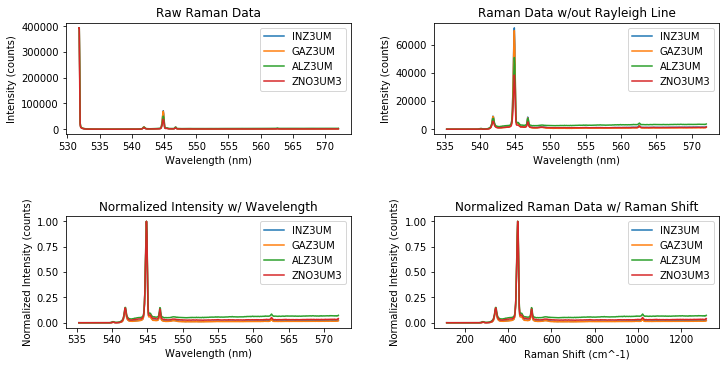

In [17]:
#setup 4 subplots 
fig, ((ax1, ax2),(ax3, ax4))= plt.subplots(nrows=2, ncols=2,figsize=(10,5))
#raw data plot
ax1=plt.subplot(2,2,1)
df.plot(x='Wavelength_1', y=y1, ax=ax1)
ax1.set_title("Raw Raman Data")
plt.legend(molecule_names)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Intensity (counts)')
#witout rayleigh line
ax2=plt.subplot(2,2,2)
df_no_rayleigh.plot(x='Wavelength_1', y=y2, ax=ax2)
ax2.set_title("Raman Data w/out Rayleigh Line")
plt.legend(molecule_names)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Intensity (counts)')
#normalized
ax3=plt.subplot(2,2,3)
df_normalized.plot(x='Wavelength_1', y=y3, ax=ax3)
ax3.set_title("Normalized Intensity w/ Wavelength")
plt.legend(molecule_names)
ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('Normalized Intensity (counts)')
#raman shift
ax4=plt.subplot(2,2,4)
df_raman_shift.plot(x='Wavelength_1', y=y4, ax=ax4)
ax4.set_title("Normalized Raman Data w/ Raman Shift")
plt.legend(molecule_names)
ax4.set_xlabel('Raman Shift (cm^-1)')
ax4.set_ylabel('Normalized Intensity (counts)')
#add y x lables and titles
#fix spacing of graphs
#Intensity (counts)
#Normalized Intensity (counts)
plt.tight_layout(pad=0.4, w_pad=3.0, h_pad=3.5)
plt.savefig("/home/jasonk0401/Desktop/UROP/RamanGraphs.png", dpi=300)
plt.show()